# **Sensor Fault Detection**

### **Data:** Sensor Data

### **Problem Statement.**
- The system in focus is the Air Pressure System (APS) which generates pressurized air that gets utilized in various functions in a truck, such as braking and gear changes. The dataset's positive class corresponds to component failures for a specific component of the APS system. The negative class corresponds to trucks with failures for components not related to the APS system.

- The problem is to reduce the cost due to unnecessary repairs. So it is required to minimize false predictions.

### **Challenges and other objectives.**

- Need to handle many null values in almost all columns.
- No low-latency requirement.
- Interpretability is not important.
- Misclassification leads the unnecessary repair costs.

In [ ]:
!pip install catboost
!pip install miceforest

In [ ]:
# Import Library.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mean
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
)
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    plot_confusion_matrix,
)
import warnings

warnings.filterwarnings("ignore")

In [ ]:
# Load Dataset.
df = pd.read_csv("sensor_data.csv", na_values="na")
df.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,pos,153204,0.0,182.0,NaN,0.0,0.0,0.0,0.0,0.0,...,129862.0,26872.0,34044.0,22472.0,34362.0,0.0,0.0,0.0,0.0,0.0
1,pos,453236,NaN,2926.0,NaN,0.0,0.0,0.0,0.0,222.0,...,7908038.0,3026002.0,5025350.0,2025766.0,1160638.0,533834.0,493800.0,6914.0,0.0,0.0
2,pos,72504,NaN,1594.0,1052.0,0.0,0.0,0.0,244.0,178226.0,...,1432098.0,372252.0,527514.0,358274.0,332818.0,284178.0,3742.0,0.0,0.0,0.0
3,pos,762958,NaN,NaN,NaN,NaN,NaN,776.0,281128.0,2186308.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,pos,695994,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,...,1397742.0,495544.0,361646.0,28610.0,5130.0,212.0,0.0,0.0,NaN,NaN


In [ ]:
# Dataset Shape.
df.shape

(36188, 171)

In [ ]:
# Check the unique values of the target variable.
df["class"].value_counts()

neg    35188
pos     1000
Name: class, dtype: int64

In [ ]:
# Define numerical & categorical columns.
numeric_features = [feature for feature in df.columns if df[feature].dtype != "O"]
categorical_features = [feature for feature in df.columns if df[feature].dtype == "O"]

print(f"We have {len(numeric_features)} numerical features: {numeric_features}")
print(f"We have {len(categorical_features)} categorical features: {categorical_features}")

We have 170 numerical features: ['aa_000', 'ab_000', 'ac_000', 'ad_000', 'ae_000', 'af_000', 'ag_000', 'ag_001', 'ag_002', 'ag_003', 'ag_004', 'ag_005', 'ag_006', 'ag_007', 'ag_008', 'ag_009', 'ah_000', 'ai_000', 'aj_000', 'ak_000', 'al_000', 'am_0', 'an_000', 'ao_000', 'ap_000', 'aq_000', 'ar_000', 'as_000', 'at_000', 'au_000', 'av_000', 'ax_000', 'ay_000', 'ay_001', 'ay_002', 'ay_003', 'ay_004', 'ay_005', 'ay_006', 'ay_007', 'ay_008', 'ay_009', 'az_000', 'az_001', 'az_002', 'az_003', 'az_004', 'az_005', 'az_006', 'az_007', 'az_008', 'az_009', 'ba_000', 'ba_001', 'ba_002', 'ba_003', 'ba_004', 'ba_005', 'ba_006', 'ba_007', 'ba_008', 'ba_009', 'bb_000', 'bc_000', 'bd_000', 'be_000', 'bf_000', 'bg_000', 'bh_000', 'bi_000', 'bj_000', 'bk_000', 'bl_000', 'bm_000', 'bn_000', 'bo_000', 'bp_000', 'bq_000', 'br_000', 'bs_000', 'bt_000', 'bu_000', 'bv_000', 'bx_000', 'by_000', 'bz_000', 'ca_000', 'cb_000', 'cc_000', 'cd_000', 'ce_000', 'cf_000', 'cg_000', 'ch_000', 'ci_000', 'cj_000', 'ck_000',

### For Sensor Data, Interpretation of the data is not required.

### Check Missing Values.

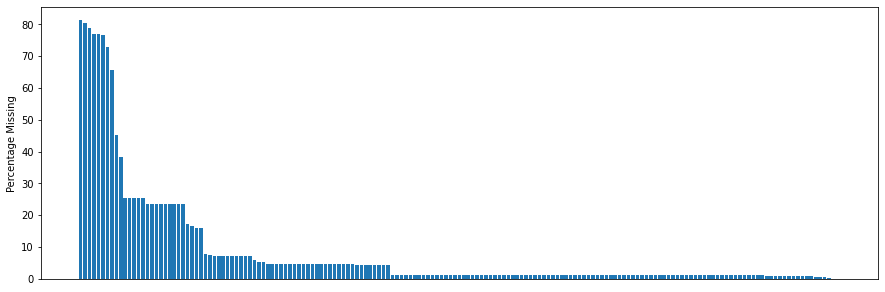

In [ ]:
# Plot Missing values count for each column.
fig, ax = plt.subplots(figsize=(15, 5))

missing = (
    df.isna()
    .sum()
    .div(df.shape[0])
    .mul(100)
    .to_frame()
    .sort_values(by=0, ascending=False)
)

ax.bar(missing.index, missing.values.T[0])
plt.xticks([])
plt.ylabel("Percentage Missing")
plt.show()

In [ ]:
# Drop columns which has more than 70% of missing values.
dropcols = missing[missing[0] > 70]
dropcols

,0
br_000,81.410965
bq_000,80.501824
bp_000,78.794075
ab_000,77.086327
cr_000,77.086327
bo_000,76.533658
bn_000,72.761689


In [ ]:
df.drop(list(dropcols.index), axis=1, inplace=True)

Check the total percentage of missing values of the entire dataset after dropping columns with more than 70% of missing values.

In [ ]:
missing_values_count = df.isnull().sum()
total_cells = np.product(df.shape)
total_missing = missing_values_count.sum()
print(f"Percentage of total missing cells {(total_missing/total_cells) * 100}%")

Percentage of total missing cells 5.37059852747306%


### Visualization of unique values in Target variable.

Positive: 1000, Negative: 35188


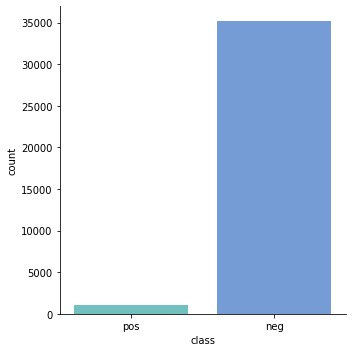

In [ ]:
pos = df[df["class"] == "pos"].shape[0]
neg = df[df["class"] == "neg"].shape[0]
print(f"Positive: {str(pos)}, Negative: {str(neg)}")
sns.catplot(data=df, x="class", kind="count", palette="winter_r", alpha=0.6)
plt.show()

### **Report.**

- The target class is highly imbalanced.
- Class imbalance is a scenario that arises when we have unequal distribution of class in a dataset, i.e., the no. of data points in the negative class (majority class) is very large compared to that of the positive class (minority class).
- If the imbalanced data is not treated beforehand, then this will degrade the performance of the classifier model.
- Hence we should handle imbalanced data with certain methods.

### **How to handle Imbalance Data?**

- Resampling data is one of the most commonly preferred approaches to deal with an imbalanced dataset. There are broadly two main types of methods for this. i) **Undersampling** and ii) **Oversampling**. In most cases, oversampling get preferred over undersampling techniques. In undersampling, we tend to remove instances from data that may have some important information.
- **SMOTE:** Synthetic Minority Oversampling Technique. SMOTE is an oversampling technique where synthetic samples get generated for the minority class.
- Hybridization techniques involve combining both undersampling and oversampling techniques. It is done to optimize the performance of classifier models for the samples created as part of these techniques.

## Functions for Model Training and Evaluation.

In [ ]:
def evaluate_clf(true, predicted):
    """
    This function takes in actual values and predicted values.
    Returns: Accuracy, F1-Score, Precision, Recall, Roc-Auc Score.
    """
    acc = accuracy_score(true, predicted)
    f1 = f1_score(true, predicted)
    precision = precision_score(true, predicted)
    recall = recall_score(true, predicted)
    roc_auc = roc_auc_score(true, predicted)
    return acc, f1, precision, recall, roc_auc


def total_cost(y_true, y_pred):
    """
    This function takes y_true and y_pred and prints the total cost due to misclassification.
    """
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return 10 * fp + 500 * fn


# Function to evaluate models and return a report.
def evaluate_models(X, y, models):
    """
    This function takes in X and y and models the dictionary as input.
    It splits the dataset into training and testing sets.
    Iterates through the given model dictionary and evaluates the metrics.
    Returns: The Dataframe contains the report of all model metrics with cost.
    """
    # Split dataset into train and test sets.
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    cost_list = []
    models_list = []

    for i in range(len(list(models))):
        model = list(models.values())[i]
        model.fit(X_train, y_train)

        # Make Predictions.
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Train Set Performance.
        (
            model_train_accuracy,
            model_train_f1,
            model_train_precision,
            model_train_recall,
            model_train_rocauc_score,
        ) = evaluate_clf(y_train, y_train_pred)
        train_cost = total_cost(y_train, y_train_pred)

        # Test Set Performance.
        (
            model_test_accuracy,
            model_test_f1,
            model_test_precision,
            model_test_recall,
            model_test_rocauc_score,
        ) = evaluate_clf(y_test, y_test_pred)
        test_cost = total_cost(y_test, y_test_pred)

        print(list(models.keys())[i])
        models_list.append(list(models.keys())[i])

        print("Model Performance for Training Set.")
        print("- Accuracy: {:.4f}".format(model_train_accuracy))
        print("- F1 score: {:.4f}".format(model_train_f1))
        print("- Precision: {:.4f}".format(model_train_precision))
        print("- Recall: {:.4f}".format(model_train_recall))
        print("- ROC-AUC Score: {:.4f}".format(model_train_rocauc_score))
        print(f"- COST: {train_cost}.")

        print("----------------------------------")

        print("Model Performance for Testing Set.")
        print("- Accuracy: {:.4f}".format(model_test_accuracy))
        print("- F1 score: {:.4f}".format(model_test_f1))
        print("- Precision: {:.4f}".format(model_test_precision))
        print("- Recall: {:.4f}".format(model_test_recall))
        print("- ROC-AUC Score: {:.4f}".format(model_test_rocauc_score))
        print(f"- COST: {test_cost}.")
        cost_list.append(test_cost)
        print("=" * 35)
        print("\n")

    return pd.DataFrame(
        list(zip(models_list, cost_list)), columns=["Model Name", "Cost"]
    ).sort_values(by=["Cost"])

### Plot Distribution of all Independent Numerical Variables.

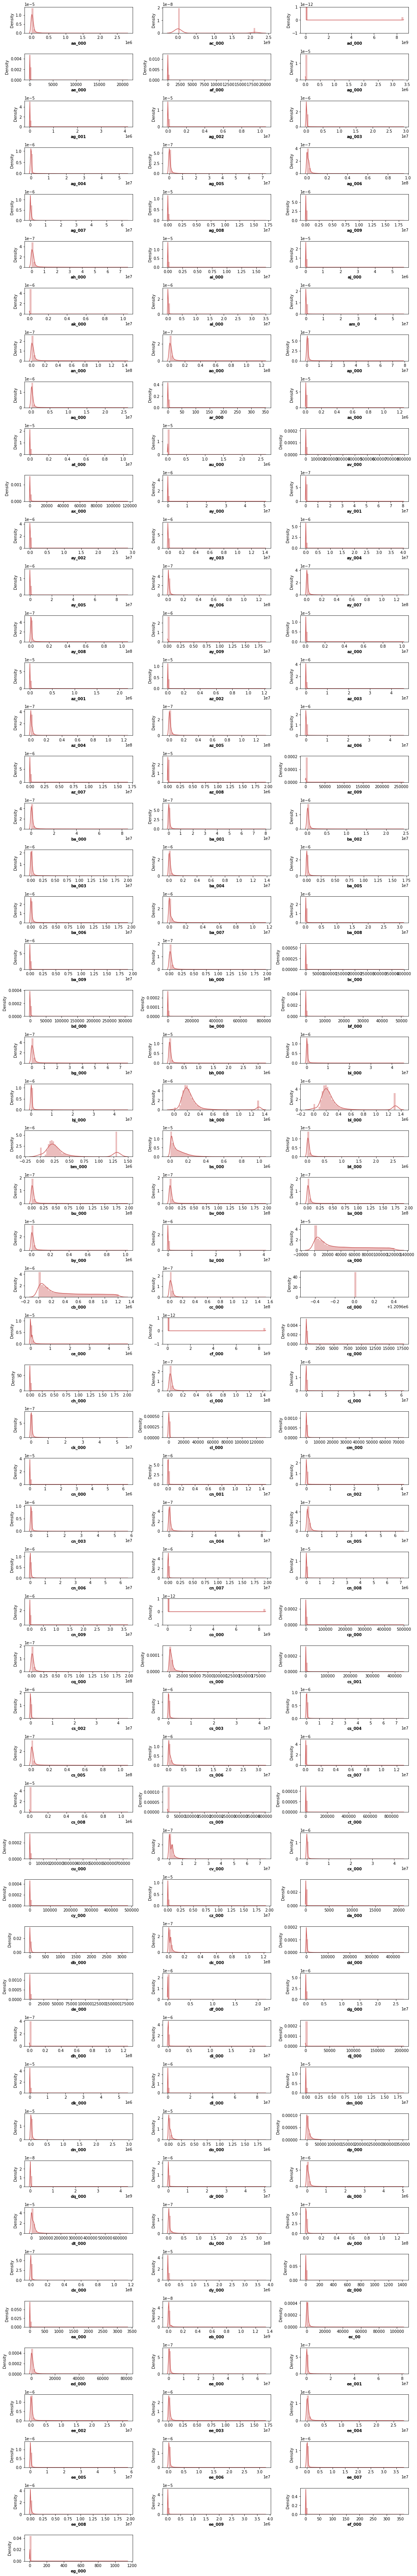

In [ ]:
numeric_features = [feature for feature in df.columns if df[feature].dtype != "O"]

plt.figure(figsize=(15, 100))
for i, col in enumerate(numeric_features):
    plt.subplot(60, 3, i + 1)
    sns.distplot(x=df[col], color="indianred")
    plt.xlabel(col, weight="bold")
    plt.tight_layout()

### **Reports.**
- As per the above plot, most features are not normally distributed.
- The transformation of data is not of prime importance since it is a classification problem.
- Interpreting each and every column is not necessary, as this is sensor data.

## Evaluate Model on Different Experiments.

In [ ]:
# Split X and y for all experiments.
X = df.drop("class", axis=1)
y = df["class"]

- **Manually Encoding Target Variable.**

In [ ]:
y = y.replace({"pos": 1, "neg": 0})

### **Experiment: 1 = KNN Imputer for Null values.**

- KNN Imputer by scikit-learn is a widely used method to impute missing values. It is widely observed as a replacement for traditional imputation techniques.
- KNN Imputer imputes missing values present in the observations by finding the nearest neighbors with the Euclidean distance matrix.
- Here we iterate through different $K$ values and choose the best $K$ value.

**Find the optimal $n\_neighbour$ value for the KNN imputer.**

In [ ]:
results = []
# Define Imputer.
imputer = KNNImputer(n_neighbors=5, weights="uniform", metric="nan_euclidean")
strategies = [str(i) for i in [1, 3, 5, 7, 9]]
for s in strategies:
    pipeline = Pipeline(
        steps=[("i", KNNImputer(n_neighbors=int(s))), ("m", LogisticRegression())]
    )
    scores = cross_val_score(pipeline, X, y, scoring="accuracy", cv=2, n_jobs=-1)
    results.append(scores)
    print("n_neighbors= %s || accuracy (%.4f)" % (s, mean(scores)))

n_neighbors= 1 || accuracy (0.9843)
n_neighbors= 3 || accuracy (0.9843)
n_neighbors= 5 || accuracy (0.9841)
n_neighbors= 7 || accuracy (0.9844)
n_neighbors= 9 || accuracy (0.9844)


**We observe $n\_neighbors=7$ and $n\_neighbors=9$ produce the highest accuracy.**

### Pipeline for KNN Imputer.

In [ ]:
num_features = X.select_dtypes(exclude="object").columns

# Fit the KNN imputer with the selected K-value.
knn_pipeline = Pipeline(
    steps=[("imputer", KNNImputer(n_neighbors=7)), ("RobustScaler", RobustScaler())]
)

X_knn = knn_pipeline.fit_transform(X)

## **Handle Imbalanced Dataset.**

$SMOTE+TOMEK$ is a hybrid technique that aims to clean overlapping data points for each class distributed in sample space.
 
This method combines the SMOTE's ability to generate synthetic data for the minority class and the Tomek link's ability to remove the data that are identified as Tomek links from the majority class.
 
 - **To add new data on minority classes:**
 1. Choose random data from the minority class.
 2. Calculate the distance between the random data and its $K$ nearest neighbors.
 3. Multiply the difference with a random number between 0 and 1, then add the result to the minority class as a synthetic sample.
 4. Repeat steps 2-3 until the desired proportion of minority class is met.
 
 - **To remove the Tomek links of the majority classes:**
 1. Choose random data from the majority class.
 2. If the random data's nearest neighbor is the data from the minority class (i.e., create the Tomek Link), then remove the Tomek Link.

**In this method instead of adding duplicate data, it synthesizes the new data based on the already available classes. Hence we choose this as our imputer method for this problem.**

In [ ]:
from imblearn.combine import SMOTETomek

# Resampling the minority class. The strategy can be changed as required.
smt = SMOTETomek(random_state=42, sampling_strategy="minority", n_jobs=-1)

# Fit the model to generate the data.
X_res, y_res = smt.fit_resample(X_knn, y)

### Initialize Default Models in a dictionary.

In [ ]:
# Dictionary contains models for the experiment.
models = {
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Logistic Regression": LogisticRegression(),
    "K-Neighbors Classifier": KNeighborsClassifier(),
    "XGBClassifier": XGBClassifier(),
    "CatBoosting Classifier": CatBoostClassifier(verbose=False),
    "AdaBoost Classifier": AdaBoostClassifier(),
}

### Fit the KNN imputed data for models in the dictionary.

In [ ]:
report_knn = evaluate_models(X_res, y_res, models)

Random Forest
Model Performance for Training Set.
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- ROC-AUC Score: 1.0000
- COST: 0.
----------------------------------
Model Performance for Testing Set.
- Accuracy: 0.9929
- F1 score: 0.9929
- Precision: 0.9890
- Recall: 0.9969
- ROC-AUC Score: 0.9929
- COST: 11780.


Decision Tree
Model Performance for Training Set.
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- ROC-AUC Score: 1.0000
- COST: 0.
----------------------------------
Model Performance for Testing Set.
- Accuracy: 0.9861
- F1 score: 0.9862
- Precision: 0.9807
- Recall: 0.9917
- ROC-AUC Score: 0.9861
- COST: 30370.


Gradient Boosting
Model Performance for Training Set.
- Accuracy: 0.9839
- F1 score: 0.9840
- Precision: 0.9803
- Recall: 0.9876
- ROC-AUC Score: 0.9839
- COST: 179060.
----------------------------------
Model Performance for Testing Set.
- Accuracy: 0.9844
- F1 score: 0.9844
- Precision: 0.9813
- Recall: 0

### Report for KNN Imputed Data.

In [ ]:
report_knn

,Model Name,Cost
6,CatBoosting Classifier,8540
0,Random Forest,11780
1,Decision Tree,30370
4,K-Neighbors Classifier,39850
5,XGBClassifier,43840
2,Gradient Boosting,44820
7,AdaBoost Classifier,83290
3,Logistic Regression,302020


### **Insights.**

- For Experiment 1: KNN Imputer has CatBoosting Classifier as the Best Model.

### **Experiment: 2 = Simple Imputer with Strategy Median.**

- $SimpleImputer$ replaces missing values in a dataset using a variety of input strategies. This technique imputes multiple columns at once by passing in a list of column names.

In [ ]:
num_features = X.select_dtypes(exclude="object").columns

# Fit the SimpleImputer with the strategy "median".
median_pipeline = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("RobustScaler", RobustScaler()),
    ]
)

# Fit X with median_pipeline.
X_median = median_pipeline.fit_transform(X)

# Resampling the minority class. The strategy can be changed as required.
smt = SMOTETomek(random_state=42, sampling_strategy="minority")

# Fit the model to generate the data.
X_res, y_res = smt.fit_resample(X_median, y)

# Train the models.
report_median = evaluate_models(X_res, y_res, models)

Random Forest
Model Performance for Training Set.
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- ROC-AUC Score: 1.0000
- COST: 0.
----------------------------------
Model Performance for Testing Set.
- Accuracy: 0.9912
- F1 score: 0.9913
- Precision: 0.9857
- Recall: 0.9969
- ROC-AUC Score: 0.9911
- COST: 12020.


Decision Tree
Model Performance for Training Set.
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- ROC-AUC Score: 1.0000
- COST: 0.
----------------------------------
Model Performance for Testing Set.
- Accuracy: 0.9854
- F1 score: 0.9856
- Precision: 0.9803
- Recall: 0.9909
- ROC-AUC Score: 0.9853
- COST: 33410.


Gradient Boosting
Model Performance for Training Set.
- Accuracy: 0.9840
- F1 score: 0.9840
- Precision: 0.9813
- Recall: 0.9867
- ROC-AUC Score: 0.9840
- COST: 190760.
----------------------------------
Model Performance for Testing Set.
- Accuracy: 0.9809
- F1 score: 0.9812
- Precision: 0.9755
- Recall: 0

### Report for Simple Imputer with $median$ strategy.

In [ ]:
report_median

,Model Name,Cost
6,CatBoosting Classifier,5760
0,Random Forest,12020
1,Decision Tree,33410
5,XGBClassifier,40140
2,Gradient Boosting,48250
4,K-Neighbors Classifier,54430
7,AdaBoost Classifier,87120
3,Logistic Regression,307620


### **Insights.**

- For Experiment 2: $SimpleImputer$ with $median$ strategy has the CatBoosting Classifier as the Best Model.

### **Experiment: 3 = MICE for Imputing Null values.**

*   MICE stands for **Multivariate Imputation By Chained Equations**, is a technique by which we can effortlessly impute missing values in a dataset by looking at data from other columns and trying to estimate the best prediction for each missing value.
*   `ImputationKernel` creates a kernel dataset. This dataset can perform MICE on itself and impute new data from models obtained during MICE.



In [ ]:
import miceforest as mf

X_mice = X.copy()

kernel = mf.ImputationKernel(X_mice, save_all_iterations=True, random_state=42)

X_mice = kernel.complete_data()

# Fit Robust Scaler.
mice_pipeline = Pipeline(steps=[("RobustScaler", RobustScaler())])

# Fit X with Mice Imputer.
X_mice = mice_pipeline.fit_transform(X_mice)

# Resampling the minority class. The strategy can be changed as required.
smt = SMOTETomek(random_state=42, sampling_strategy="minority", n_jobs=-1)

# Fit the model to generate the data.
X_res, y_res = smt.fit_resample(X_mice, y)

# Train the Models.
report_mice = evaluate_models(X_res, y_res, models)

Random Forest
Model Performance for Training Set.
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- ROC-AUC Score: 1.0000
- COST: 0.
----------------------------------
Model Performance for Testing Set.
- Accuracy: 0.9904
- F1 score: 0.9904
- Precision: 0.9849
- Recall: 0.9960
- ROC-AUC Score: 0.9904
- COST: 15070.


Decision Tree
Model Performance for Training Set.
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- ROC-AUC Score: 1.0000
- COST: 0.
----------------------------------
Model Performance for Testing Set.
- Accuracy: 0.9839
- F1 score: 0.9840
- Precision: 0.9784
- Recall: 0.9896
- ROC-AUC Score: 0.9839
- COST: 38030.


Gradient Boosting
Model Performance for Training Set.
- Accuracy: 0.9855
- F1 score: 0.9856
- Precision: 0.9823
- Recall: 0.9889
- ROC-AUC Score: 0.9855
- COST: 161000.
----------------------------------
Model Performance for Testing Set.
- Accuracy: 0.9806
- F1 score: 0.9807
- Precision: 0.9757
- Recall: 0

### Report for MICE Imputer algorithm.

In [ ]:
report_mice

,Model Name,Cost
6,CatBoosting Classifier,8640
0,Random Forest,15070
1,Decision Tree,38030
5,XGBClassifier,42110
2,Gradient Boosting,51720
4,K-Neighbors Classifier,72080
7,AdaBoost Classifier,92770
3,Logistic Regression,193810


### **Insights.**

- For Experiment 3: Mice Imputer has CatBoosting Classifier as the Best Model.

### **Experiment: 4 = Simple Imputer with Strategy Constant.**

- Another strategy is to replace missing values with a fixed (constant) value.

In [ ]:
# Fit the SimpleImputer with the strategy "constant" and fill value 0.
constant_pipeline = Pipeline(
    steps=[
        ("Imputer", SimpleImputer(strategy="constant", fill_value=0)),
        ("RobustScaler", RobustScaler()),
    ]
)

X_const = constant_pipeline.fit_transform(X)

# Resampling the minority class. The strategy can be changed as required.
smt = SMOTETomek(random_state=42, sampling_strategy="minority", n_jobs=-1)

# Fit the model to generate the data.
X_res, y_res = smt.fit_resample(X_const, y)

# Train the Models.
report_const = evaluate_models(X_res, y_res, models)

Random Forest
Model Performance for Training Set.
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- ROC-AUC Score: 1.0000
- COST: 0.
----------------------------------
Model Performance for Testing Set.
- Accuracy: 0.9931
- F1 score: 0.9931
- Precision: 0.9897
- Recall: 0.9966
- ROC-AUC Score: 0.9931
- COST: 12730.


Decision Tree
Model Performance for Training Set.
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- ROC-AUC Score: 1.0000
- COST: 0.
----------------------------------
Model Performance for Testing Set.
- Accuracy: 0.9874
- F1 score: 0.9875
- Precision: 0.9817
- Recall: 0.9933
- ROC-AUC Score: 0.9874
- COST: 24800.


Gradient Boosting
Model Performance for Training Set.
- Accuracy: 0.9829
- F1 score: 0.9829
- Precision: 0.9799
- Recall: 0.9860
- ROC-AUC Score: 0.9829
- COST: 201670.
----------------------------------
Model Performance for Testing Set.
- Accuracy: 0.9806
- F1 score: 0.9807
- Precision: 0.9774
- Recall: 0

### Report for Simple Imputer with $constant$ strategy.

In [ ]:
report_const

,Model Name,Cost
6,CatBoosting Classifier,4470
0,Random Forest,12730
1,Decision Tree,24800
4,K-Neighbors Classifier,43200
5,XGBClassifier,50560
2,Gradient Boosting,57600
7,AdaBoost Classifier,98790
3,Logistic Regression,115440


### **Insights.**

- For Experiment 4: $SimpleImputer$ with $constant$ strategy has CatBoosting Classifier as the Best Model.

### **Experiment: 5 = Simple Imputer with Strategy Mean.**

- Another strategy is to replace missing values with the mean of the column.

In [ ]:
# Fit the SimpleImputer with the strategy "mean".
mean_pipeline = Pipeline(
    steps=[
        ("Imputer", SimpleImputer(strategy="mean")),
        ("RobustScaler", RobustScaler()),
    ]
)

X_mean = mean_pipeline.fit_transform(X)

# Resampling the minority class. The strategy can be changed as required.
smt = SMOTETomek(random_state=42, sampling_strategy="minority", n_jobs=-1)

# Fit the model to generate the data.
X_res, y_res = smt.fit_resample(X_mean, y)

# Train the Models.
report_mean = evaluate_models(X_res, y_res, models)

Random Forest
Model Performance for Training Set.
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- ROC-AUC Score: 1.0000
- COST: 0.
----------------------------------
Model Performance for Testing Set.
- Accuracy: 0.9940
- F1 score: 0.9940
- Precision: 0.9903
- Recall: 0.9977
- ROC-AUC Score: 0.9941
- COST: 8680.


Decision Tree
Model Performance for Training Set.
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- ROC-AUC Score: 1.0000
- COST: 0.
----------------------------------
Model Performance for Testing Set.
- Accuracy: 0.9864
- F1 score: 0.9863
- Precision: 0.9839
- Recall: 0.9886
- ROC-AUC Score: 0.9864
- COST: 40620.


Gradient Boosting
Model Performance for Training Set.
- Accuracy: 0.9856
- F1 score: 0.9857
- Precision: 0.9828
- Recall: 0.9886
- ROC-AUC Score: 0.9856
- COST: 164880.
----------------------------------
Model Performance for Testing Set.
- Accuracy: 0.9865
- F1 score: 0.9863
- Precision: 0.9835
- Recall: 0.

### Report for Simple Imputer with $mean$ strategy.

In [ ]:
report_mean

,Model Name,Cost
6,CatBoosting Classifier,5960
0,Random Forest,8680
2,Gradient Boosting,38650
1,Decision Tree,40620
5,XGBClassifier,42020
4,K-Neighbors Classifier,44770
7,AdaBoost Classifier,90980
3,Logistic Regression,301660


### **Insights.**

- For Experiment 5: $SimpleImputer$ with $mean$ strategy has the CatBoosting Classifier as the Best Model.

# Final Model Selection.

In [ ]:
from prettytable import PrettyTable

pt = PrettyTable()
pt.field_names = ["Model", "Imputation_method", "Total_cost"]
pt.add_row(["CatBoostClassifier", "Simple Imputer-Constant", "4470"])
pt.add_row(["CatBoostClassifier", "Simple Imputer-Median", "5760"])
pt.add_row(["CatBoostClassifier", "Simple Imputer-Mean", "5960"])
pt.add_row(["CatBoostClassifier", "KNN Imputer", "8540"])
pt.add_row(["CatBoostClassifier", "MICE", "8640"])
print(pt)

+--------------------+-------------------------+------------+
|       Model        |    Imputation_method    | Total_cost |
+--------------------+-------------------------+------------+
| CatBoostClassifier | Simple Imputer-Constant |    4470    |
| CatBoostClassifier |  Simple Imputer-Median  |    5760    |
| CatBoostClassifier |   Simple Imputer-Mean   |    5960    |
| CatBoostClassifier |       KNN Imputer       |    8540    |
| CatBoostClassifier |           MICE          |    8640    |
+--------------------+-------------------------+------------+


### **Insights.**

- Based on the final report, the **CatBoost Classifier** with $SimpleImputer$ and strategy $constant$ has the best cost value of 4470.

# Fit the Final Model and Get Reports.

Final XGBoost Classifier Cost Metric (Test): 4470


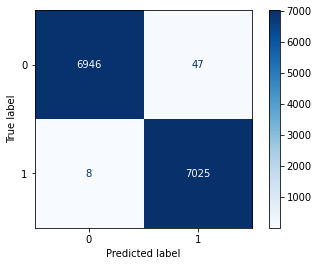

In [ ]:
final_model = CatBoostClassifier(verbose=False)

# Resampling the minority class. The strategy can be changed as required.
smt = SMOTETomek(random_state=42, sampling_strategy="minority", n_jobs=-1)

# Fit the model to generate the data.
X_res, y_res = smt.fit_resample(X_const, y)

X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.2, random_state=42
)

final_model = final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)

print("Final XGBoost Classifier Cost Metric (Test):", total_cost(y_test, y_pred))

plot_confusion_matrix(final_model, X_test, y_test, cmap="Blues", values_format="d")

# The Best Model is the XGBoost Classifier with 99.6% accuracy and a cost of 4470.